In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# creating train and test dataset

In [11]:
def getData(type):
    df = list()
    directory = f'D-Fire/{type}/labels' 
    n = len(os.listdir(directory))
    for filename in tqdm(os.listdir(directory)):
        f = os.path.join(directory, filename)
        # print(f)

        image = filename[:-3] + 'jpg'
        # print(image)
        # break
        img = Image.open(f'D-Fire/{type}/images/{image}')
        width, height = img.size
        # print(width, height)
        # plt.imshow(img)
        # plt.show()
        # break
        pre = [image, width, height]
        if os.path.getsize(f) == 0:
            dp = pre + [2]
            df.append(dp)
        else:
            with open(f) as fp:
                lines = fp.readlines()
                for line in lines:
                    line = line.split()
                    line = list(map(float, line))
                    if len(line) != 0:
                        line[0] = int(line[0])
                        # line.insert(0, image)
                        dp = pre + line
                        df.append(dp)
            fp.close()
    return df, n

In [12]:
# get train and test data
train, n_train = getData("train")
df_train = pd.DataFrame(train, columns= ["Image", "Width", "Height", "Label", "x_min", "y_min", "x_max", "y_max"])
test, n_test = getData("test")
df_test = pd.DataFrame(test, columns= ["Image", "Width", "Height", "Label", "x_min", "y_min", "x_max", "y_max"])

100%|██████████| 4306/4306 [00:00<00:00, 5038.54it/s]


In [13]:
# train sample
df_train.head()

Image  Width  Height  Label     x_min     y_min     x_max     y_max
0  AoF05695.jpg   1280     720      0  0.700781  0.379167  0.039062  0.105556
1  WEB08898.jpg    640     360      0  0.477344  0.291667  0.264063  0.555556
2  WEB01102.jpg    640     360      2       NaN       NaN       NaN       NaN
3  WEB07573.jpg   1100     619      0  0.465000  0.475767  0.290000  0.906300
4  WEB08640.jpg    640     360      0  0.578125  0.506944  0.709375  0.936111

In [32]:
class_0 = df_train[df_train["Label"] == 0].sample(n = 2).to_numpy()
class_1 = df_train[df_train["Label"] == 1].sample(n = 2).to_numpy()
class_2 = df_train[df_train["Label"] == 2].sample(n = 2).to_numpy()
images = np.concatenate((class_0, class_1, class_2))
images

array([['WEB06357.jpg', 800, 448, 0, 0.45937500000000003,
        0.36607142857142855, 0.21375, 0.5491071428571428],
       ['AoF06025.jpg', 1280, 720, 0, 0.525, 0.38958333333333334,
        0.0390625, 0.059722222222222225],
       ['WEB05779.jpg', 640, 352, 1, 0.039843750000000004, 0.78125,
        0.06406250000000001, 0.0625],
       ['WEB05164.jpg', 640, 360, 1, 0.8078125, 0.4902777777777778,
        0.16875, 0.4083333333333333],
       ['WEB02502.jpg', 750, 562, 2, nan, nan, nan, nan],
       ['WEB02906.jpg', 1423, 755, 2, nan, nan, nan, nan]], dtype=object)

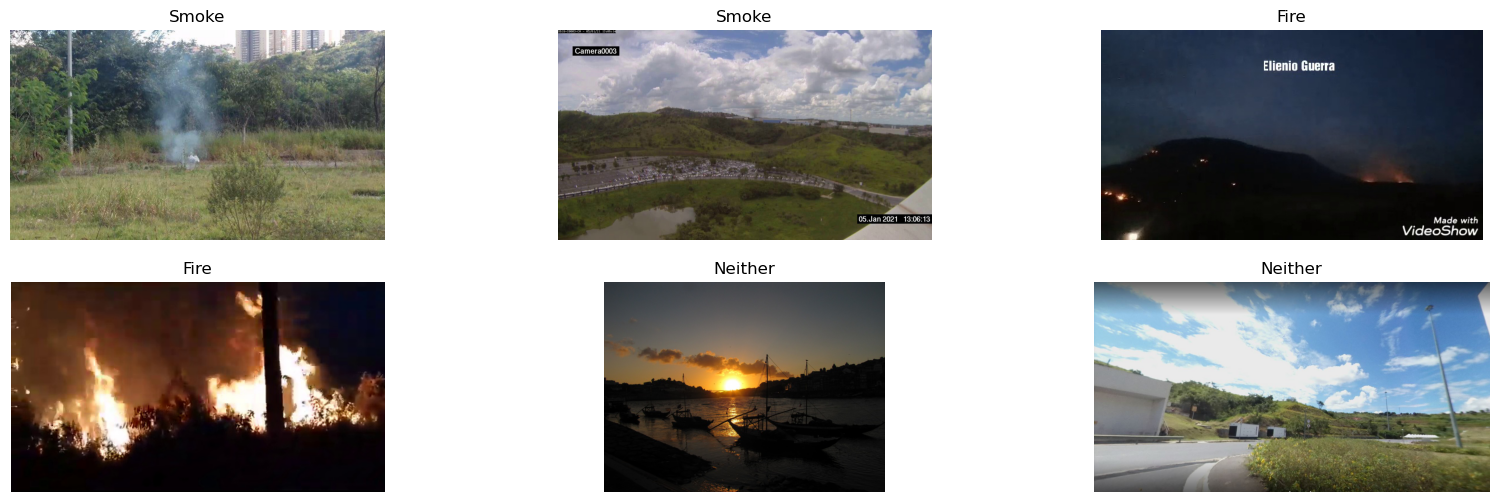

In [33]:
images = np.concatenate((class_0, class_1, class_2))
num_images = len(images)

fig, axes = plt.subplots(2, 3, figsize=(20, 6))  # 2 rows, 3 columns for 6 images

for i in range(num_images):
    row, col = divmod(i, 3)
    path = f"D-Fire/train/images/{images[i][0]}"
    axes[row, col].imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))
    if images[i][3] == 0:
        label = "Smoke"
    elif images[i][3] == 1:
        label = "Fire"
    else:
        label = "Neither"
    axes[row, col].set_title(label)
    axes[row, col].axis('off')

plt.show()

# data split exploration

In [5]:
group_tr = df_train.groupby("Label").count().iloc[:, 0].to_numpy()
group_tr_ratio = group_tr / n_train
group_te = df_test.groupby("Label").count().iloc[:, 0].to_numpy()
group_te_ratio = group_te / n_test

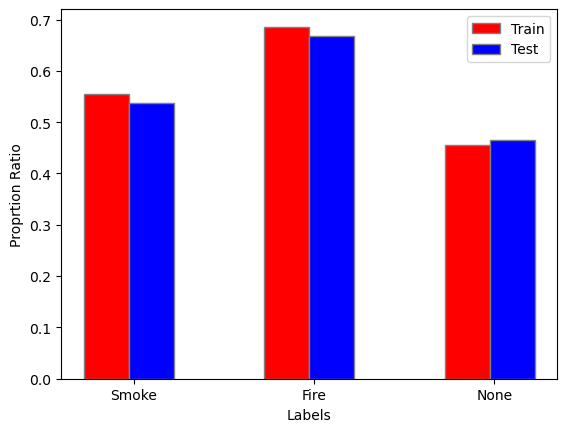

In [6]:
# statistics on data ratio split
x =  np.arange(3)
plt.bar(x, group_tr_ratio, color ='r', width  = 0.25,
        edgecolor ='grey', label ='Train')
x = [x + 0.25 for x in x]
plt.bar(x, group_te_ratio, color ='b', width  = 0.25,
        edgecolor ='grey', label ='Test')
plt.xlabel('Labels')
plt.ylabel('Proprtion Ratio')
plt.xticks([0.15, 1.15, 2.15], ["Smoke", "Fire", "None"])
plt.legend()
plt.show()

# total count for different classes

In [7]:
pd.DataFrame([group_tr, group_te], columns=["Smoke", "Fire", "Neither"], index=["Train", "Test"])

Smoke   Fire  Neither
Train   9550  11814     7833
Test    2315   2878     2005

In [8]:
df_train.groupby(["Image", "Label"]).count()["Width"]

Image         Label
AoF00000.jpg  2        1
AoF00001.jpg  1        1
AoF00002.jpg  0        1
AoF00003.jpg  2        1
AoF00004.jpg  2        1
                      ..
WEB09440.jpg  0        2
WEB09441.jpg  0        2
              1        3
WEB09442.jpg  0        1
              1        1
Name: Width, Length: 20984, dtype: int64

In [ ]:
np.random.seed(42)
idx = np.random.randint
smoke = df_train["Label"] == 0 
fire = df_train["Label"] == 1
neither = df_train["Label"] == 2
